# Machine Learning to forecast Bitcoin price movements
# Part 2: Feature Engineering with PCA

The objective of this notebook will be to **use Principal Component Analysis, to reduce the dimensionality of our dataset before using other models** to predict prices and daily returns. We will use as a benchmark for this exercise, our own adaptation from Udacity's [Machine Learning deployment case studies with AWS](https://github.com/udacity/ML_SageMaker_Studies) where PCA is used. After performin our model, we will create new data sets with reduced dimensionality, which will be prepared for use by follow-up models, in the `pca/` folder.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

We will start by sourcing the feedin datasets already prepared during our first notebook.

In [2]:
store_list = ['train_x', 'train_nx', 'test_x', 'test_nx', 'train_y', 'train_ny', 'test_y', 'test_ny']
data = {}

for i in range(len(store_list)):
    data[store_list[i]] = pd.read_csv('data/'+store_list[i]+'.csv')
    data[store_list[i]].drop(columns=['Date'], inplace=True)

data['train_x'].tail()

,shangai,btc_cumulative,crude oil,euro,gold,silver,spy,ftse,hsi,nasdaq,nikkei,rates,MA4,MA96,MA200,stochRSI,RSI,btc_std_dev,std_dif,hashrate,difficulty,transactions,t_cost,returns,btc_close,returns_label
1836,1.335581,199254.859149,0.783512,0.917545,1.086655,0.942170,2.490353,1.474798,1.472206,3.155380,2.433228,0.832321,14940.0,7436.0,4667.0,30.504255,59.348167,0.103823,16099.688169,1.257020e+07,1.873105e+12,285966876.0,146.595142,0.147804,16099.791992,2
1837,1.323324,196021.035153,0.779200,0.916414,1.089109,0.947816,2.491565,1.480236,1.473184,3.156785,2.435197,0.814440,14949.0,7558.0,4741.0,32.676696,57.450805,0.103798,15838.395225,1.322199e+07,1.873105e+12,286214316.0,161.686071,-0.016230,15838.499023,0
1838,1.331646,180773.437289,0.781813,0.919729,1.095117,0.959964,2.496691,1.480664,1.486426,3.161707,2.421674,0.820513,15143.0,7664.0,4809.0,12.651295,48.819515,0.103790,14606.389374,1.452556e+07,1.873105e+12,286521958.0,138.582976,-0.077786,14606.493164,0
1839,1.336004,181388.635430,0.789391,0.922892,1.105441,0.972967,2.487277,1.493270,1.489186,3.140431,2.419650,0.811404,15300.0,7772.0,4878.0,13.545089,49.204756,0.103764,14656.097408,1.387377e+07,1.873105e+12,286827011.0,124.845787,0.003403,14656.201172,2
1840,1.336004,169024.870251,0.789391,0.927778,1.105441,0.972967,2.487277,1.493270,1.489186,3.140431,2.419650,0.811404,14690.0,7871.0,4941.0,0.000000,41.913678,0.103752,13657.105232,1.517735e+07,1.873105e+12,287815664.0,125.970638,-0.068162,13657.208984,0


## Model preparation

To inialize our model, we first need to get Sagemaker session parameters, such as role, default bucket name and so on. We will also need to store our datasets in the default S3 bucket, in which we will create a folder for this excercise.

In [3]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::724888201472:role/service-role/AmazonSageMaker-ExecutionRole-20201115T171901


In [4]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-eu-central-1-724888201472



In [5]:
# define location to store model artifacts
prefix = 'capstone-pca'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-eu-central-1-724888201472/capstone-pca/


In [6]:
data['train_nx'].shape

(1841, 26)

## Instantiation and training
Now we will instantiate a PCA model from AWS Sagemaker, passing in the number of components that our dataset has. We also need to convert the train data into recordset format, before fitting or training the model.

In [7]:
from sagemaker import PCA

# this is current features - 1

N_COMPONENTS= data['train_nx'].shape[1] - 1

pca_model = PCA(role=role,
             instance_count=1,
             instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


In [8]:
# convert df to np array
train_data = data['train_nx'].values.astype('float32')

# To-do for later...change datetime index for a timestamp to include in model

# convert to RecordSet format
record_train = pca_model.record_set(train_data)

In [9]:
train_data

array([[3.0249995e-01, 0.0000000e+00, 8.3293748e-01, ..., 1.7739549e-01,
        0.0000000e+00, 1.0000000e+00],
       [3.0378178e-01, 5.9790631e-07, 8.3076006e-01, ..., 1.6372049e-01,
        5.9790631e-07, 1.0000000e+00],
       [2.9891202e-01, 2.8827660e-07, 8.3300346e-01, ..., 1.3622598e-01,
        2.8827660e-07, 0.0000000e+00],
       ...,
       [4.1860431e-01, 5.1983237e-01, 6.4311165e-01, ..., 1.2543532e-01,
        5.1983237e-01, 0.0000000e+00],
       [4.2195818e-01, 5.2160150e-01, 6.4693850e-01, ..., 1.4603923e-01,
        5.2160150e-01, 1.0000000e+00],
       [4.2195818e-01, 4.8604766e-01, 6.4693850e-01, ..., 1.2787762e-01,
        4.8604766e-01, 0.0000000e+00]], dtype=float32)

In [23]:
%%time

# train the PCA mode on the formatted data
pca_model.fit(record_train)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-30 15:10:46 Starting - Starting the training job...
2020-12-30 15:11:09 Starting - Launching requested ML instancesProfilerReport-1609341045: InProgress
......
2020-12-30 15:12:14 Starting - Preparing the instances for training.........
2020-12-30 15:13:45 Downloading - Downloading input data
2020-12-30 15:13:45 Training - Downloading the training image...
2020-12-30 15:14:11 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/30/2020 15:14:08 INFO 139977465911104] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[12/30/2020 15:14:08 INFO 139977465911104] Merging with provided configuration from

## Loading the model for use
**Important**: In order to use the model, we have to **note down the training job name, to provide it in the cell below** after the training job has finished. Please do so to reproduce results.

Afterwards, we will download, unzip and load our model using MXNet, so we can use it to predict reduced features out of our dataset.

In [24]:
import os
import boto3

In [25]:
# Name of the training job
training_job_name='pca-2020-12-28-23-03-27-081'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping model
os.system('tar -zxvf model.tar.gz')
os.system('unzip -o model-algo-1')

capstone-pca/pca-2020-12-28-23-03-27-081/output/model.tar.gz


2304

In [26]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[        nan  0.05652451  0.10016972  0.12433855  0.23421955  0.25136304
  0.53354037  0.6395169   1.0004538   1.109179    1.2633115   1.3936144
  1.613095    1.8647261   2.4896214   3.552215    5.027145    6.115767
  6.991929    7.3414583  10.444403   11.573331   12.069087   21.047577
 24.009825  ]
<NDArray 25 @cpu(0)>, 'v': 
[[-5.85769371e-08 -1.93733559e-03 -6.33543124e-03 -1.15119498e-02
  -1.35864429e-02 -7.64239300e-03 -5.48301749e-02 -4.32421826e-02
  -8.89479928e-03 -3.89831029e-02 -1.47493988e-01  3.41952622e-01
   2.91830450e-01 -2.40349382e-01 -4.71050069e-02  2.83541203e-01
  -7.27753267e-02  6.09976053e-02 -7.25065947e-01  9.89388600e-02
  -1.36235967e-01  9.23977867e-02 -1.55250793e-02  8.66442453e-04
  -2.38759845e-01]
 [-7.07095802e-01  1.99994892e-02 -1.59458164e-02  3.20061110e-02
  -2.36791506e-01  1.79206848e-01  1.60082474e-01 -1.54412046e-01
  -4.68134321e-03  1.95141416e-02 -1.75643757e-01 -9.53130499e-02
   5.23407646e-02  8.29343274e-02  1.36732370e-01  

## Selecting the proper amount of features
Now we need to **analyze how much variance are we willing to explain with our new features**. For this we will use the model's `s` and `v` parameters, to calculate the estimated explained variance of the top 'N' components.

In [27]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [28]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


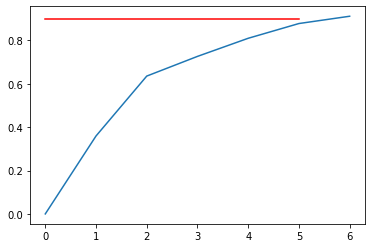

Explained variance:  0.9108686 with 6 components
Total components:  25


In [29]:
from matplotlib import pyplot as plt

alt_variate = []
def plot_variance_ncomp(s, n_top_components, cut=0.8):
    for i in range(n_top_components + 1):
        alt_variate.append(explained_variance(s, i))
        # print(i)
        alt_variate_np = np.array(alt_variate)
    # print(alt_variate_np)
    plt.plot(alt_variate_np, scaley=False)
    plt.plot(list(range(n_top_components)),[ cut for i in range(i)], color='red')
    plt.show()
    print('Explained variance: ', explained_variance(s,n_top_components), 'with',n_top_components,'components')
    print('Total components: ', len(s))
    return n_top_components
    
n_top = plot_variance_ncomp(s, 6, 0.9)

As a variance of 91% could be sufficient, **we will take the top 6 components for our analysis.**

## Analyzing our top components
Now that we've selected the number of features, we can **have a look at these selected to see which and how much weight of the original feature set is being considered** in the features selected.

In [30]:
# original feature list
features_list = data['train_nx'].columns.values
print('Features: \n', features_list)

Features: 
 ['shangai' 'btc_cumulative' 'crude oil' 'euro' 'gold' 'silver' 'spy'
 'ftse' 'hsi' 'nasdaq' 'nikkei' 'rates' 'MA4' 'MA96' 'MA200' 'stochRSI'
 'RSI' 'btc_std_dev' 'std_dif' 'hashrate' 'difficulty' 'transactions'
 't_cost' 'returns' 'btc_close' 'returns_label']


In [31]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(5,5))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


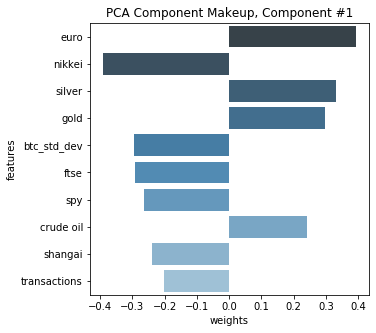

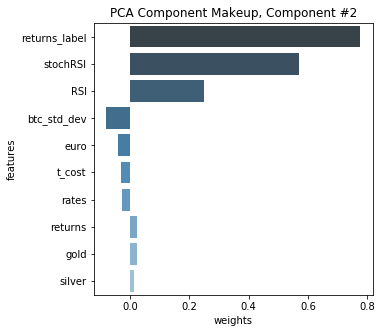

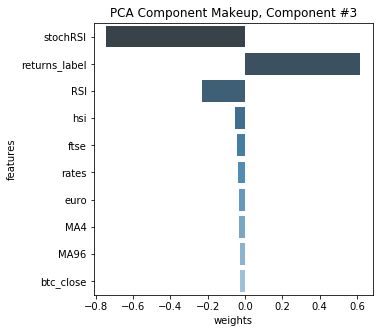

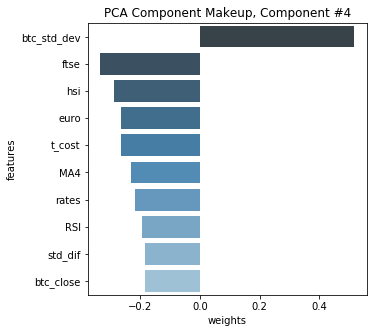

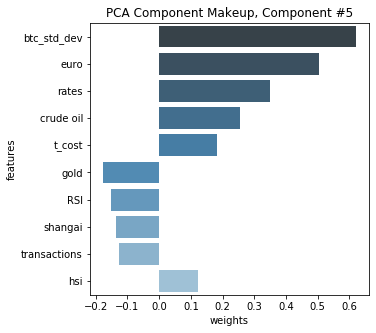

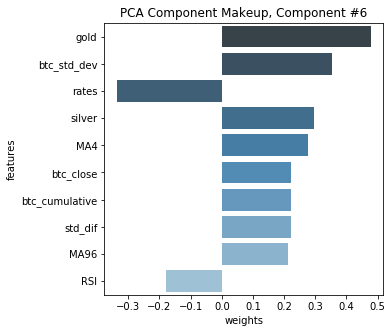

In [32]:
# display makeup of all selected components
for i in range(1, n_top + 1):
    display_component(v, data['train_nx'].columns.values, component_num=i, n_weights=10)

Interestingly, **we can observe that the model is weighting important market features in the newly created ones**, such as the most traded pair worldwide (EUR/USD), commodities (gold, silver, oil), top stock indexes (SPY, Nikkei...) and some of the technical indicators (RSI, MAs). 

## Predicting, creating and saving datasets with reduced components

After having trained our PCA model, we will use it to predict the reduced components into our train and test datasets, plus store the results in a dataframe and CSV for further use with other models. In order **to predict the reduced components, we will deploy the model to an endpoint, pass in both our train and test data and process the results, and finally store them** in the `pca/` folder. 

In [33]:
%%time
pca_predictor = pca_model.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------------!CPU times: user 313 ms, sys: 1.58 ms, total: 315 ms
Wall time: 8min 2s


In [34]:
# convert test df to np array
test_data = data['test_nx'].values.astype('float32')

# pass np test data to the PCA model
test_pca = pca_predictor.predict(test_data)

# doing the same for the training data
train_pca = pca_predictor.predict(train_data)

In [35]:
# checking out the first item in the test 
print(test_pca[0])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 8.272163540823385e-07
      values: -0.00826762430369854
      values: -0.0006801807321608067
      values: 0.005548567045480013
      values: 0.016704339534044266
      values: -0.02403828129172325
      values: -0.09908427298069
      values: 0.07538732141256332
      values: -0.0032097920775413513
      values: 0.00419216975569725
      values: -0.013965174555778503
      values: 0.027106940746307373
      values: -0.059127241373062134
      values: -0.05356582999229431
      values: 0.12886856496334076
      values: 0.112761951982975
      values: -0.3593323826789856
      values: 0.03652268648147583
      values: 0.14420023560523987
      values: 0.7124940752983093
      values: 0.030685245990753174
      values: -1.141496181488037
      values: -0.09166109561920166
      values: -0.8766021728515625
      values: -0.9396859407424927
    }
  }
}



Now that we've done the predictions with our deployed model, we will take the results and transform everything into a CSV format, and save it for further use.

In [36]:
# create dimensionality-reduced data

def create_transformed_df(train_pca, source, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The returned dataframe is indexed as original dataframes.       
     '''
    # create new dataframe to add data to
    transformed_df=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        transformed_df=transformed_df.append([list(components)])

    # index just like data source - To-Do: use dates here, we dropped them before
    transformed_df.index=source.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    transformed_df = transformed_df.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return transformed_df.iloc[:, ::-1]
    

In [37]:
# call your function and create a new dataframe
df_transformed_train = create_transformed_df(train_pca, data['train_nx'], n_top_components=n_top)
df_transformed_test = create_transformed_df(test_pca, data['test_nx'], n_top_components=n_top)

In [38]:
df_transformed_test.tail()

,24,23,22,21,20,19
864,-1.024661,-0.303106,0.032146,-1.425861,-0.524859,1.643820
865,-1.031170,-0.303869,0.031008,-1.438112,-0.519242,1.648712
866,-1.031509,-0.303930,0.031686,-1.431345,-0.519834,1.643611
867,-1.039068,-0.305782,0.029384,-1.457848,-0.509792,1.669187
868,-1.065973,-0.307797,0.025638,-1.492625,-0.491977,1.668512


In [39]:
# add column names
PCA_list=[]
for i in range(1, n_top + 1):
    PCA_list.append('component_'+str(i))
    
print(PCA_list)

['component_1', 'component_2', 'component_3', 'component_4', 'component_5', 'component_6']


In [40]:
for x in [df_transformed_train, df_transformed_test]:
    x.columns=PCA_list 
    
# print and store the result
df_transformed_test.tail()

,component_1,component_2,component_3,component_4,component_5,component_6
864,-1.024661,-0.303106,0.032146,-1.425861,-0.524859,1.643820
865,-1.031170,-0.303869,0.031008,-1.438112,-0.519242,1.648712
866,-1.031509,-0.303930,0.031686,-1.431345,-0.519834,1.643611
867,-1.039068,-0.305782,0.029384,-1.457848,-0.509792,1.669187
868,-1.065973,-0.307797,0.025638,-1.492625,-0.491977,1.668512


In [41]:
df_transformed_train.to_csv('pca/train.csv')
df_transformed_test.to_csv('pca/test.csv')

Finally we need to **delete the endpoint created** so we avoid extra charges.

In [42]:
# delete predictor endpoint
# session.delete_endpoint(pca_predictor.endpoint)

pca_predictor.delete_endpoint() # new way of deleting in Sagemaker 2.0

## Recap and Discussion

We grabbed our data features (27) and **reduced the dataset's dimendionality using Principal Component Analysis, reducing it to 6 and making sure that 91% of the variance in the dataset is preserved** by these. We also analysed the weights of the newly created features, and observed that they included relevant data, such as top stock index prices, top traded currency pairs, commodities and technical indicators used by traders.

## What's next?

On the following notebooks we will still cover:
- **XGBoost for price forecasting and trading signal**
- **Neural network for price forecasting and trading signal**
- **Final discussion and model comparison**